In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import os

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300

import sys
sys.path.append("../")

from io_utils import collect_results

from cardiac_model import CardiacModel
from solmodel import SolModel
from gene_utils import update_genes_from_state
from pypoptim.algorythm.ga import GA

In [44]:
case = "220117_121650"
case = "220120_012200"

In [45]:
dirname_results = "/home/dmitry/work/GA_mouse_SAN/new_GA_lsoda/bondarenko/configs/results/bondarenko_test"
result = collect_results(case, dirname_results, dump_keys=['best',
                                                           'dump',
                                                           ], voigt=False)
state_best_0 = pd.read_csv(os.path.join(dirname_results, case, 'state_best_0.csv'), index_col=['name'])

In [46]:
config = result['config'].copy()
state_best = result['state_best'].copy()
sol_best = result['sol_best'].copy()
phenotype_best = result['phenotype_best'].copy()
sol_best.round(2)

ec_name  g_name         
common   gna                     4.98
         knaca                   0.55
         inakmax                 3.77
         ipcamax                 1.87
         gcab                    3.51
         gnab                    3.29
         gks                     0.13
         gkto                    0.02
         gkr                     3.03
         gclca                   0.13
         CaLF                    0.49
         CaTF                   15.29
         RyR                     3.79
         jleak                   0.10
         SERCA                   0.66
         gcakF                   5.13
         ik1                     0.11
         funny                   0.37
         CaL13                  17.39
         CaL13_inact_tau         1.96
         INa_11                  0.06
         ficalcav                0.13
         fical13cav              0.01
sp       K_intra            131755.39
         Na_intra             9958.58
Name: 0, dtype: float64

In [47]:
config_copy = config.copy()

for x, y in config['experimental_conditions'].items():
    if x == 'common':
        continue
    update_genes_from_state(sol_best, state_best_0, config_copy, x)

# filename_so = "../../../../models_ctypes/src/model_ctypes/koivumaki_host.so"
filename_so = config['runtime']['filename_so_abs']
filename_so = "/home/dmitry/work/GA_mouse_SAN/new_GA_lsoda/bondarenko/model/model.so"
model = CardiacModel(filename_so)
SolModel.model = model

#del config_copy['t_run']
config_copy['n_beats'] = 1
config_copy['n_beats_save'] = 9999999

SolModel.config = config_copy
sol = SolModel(x=sol_best.copy(),
               state=state_best_0.copy())

# sol['phenotype'] = phenotype_best

ga_optim = GA(SolModel,
              bounds=config['runtime']['bounds'],
              gammas=config['runtime']['gammas'],
              gamma_default=config['runtime']['kw_ga']['gamma'],
              mutation_rate=config['runtime']['kw_ga']['mutation_rate'],
              crossover_rate=config['runtime']['kw_ga']['crossover_rate'],
              # selection_force=config['runtime']['kw_ga']['selection_force'],
              mask_log10_scale=config['runtime']['mask_multipliers'],
              keys_data_transmit=['state'])

In [48]:
exp_cond_list = [exp_cond for exp_cond in config['experimental_conditions'].items() if exp_cond[0] != 'common']

In [49]:
m_index = config['runtime']['m_index']
dump_genes = result['dump']['dump']['genes'].reshape((-1, len(m_index)))

states_index = config['runtime']['legend']['states'].index

dump_states = result['dump']['dump']['state'].reshape((-1, len(states_index) * len(exp_cond_list)))
n_organisms = config['runtime']['n_organisms']
n_generations = len(dump_genes) // n_organisms

In [50]:
index = pd.MultiIndex.from_product([range(n_generations), range(n_organisms)],
                                   names=['epoch', 'org'])
dump_genes = pd.DataFrame(dump_genes, columns=m_index, index=index)

columns_dump_state = pd.MultiIndex.from_product([states_index, [x for x, _ in exp_cond_list]],
                                   names=['name', 'CL', ])
dump_states = pd.DataFrame(dump_states, columns=columns_dump_state, index=index).swaplevel(axis=1)

dump_loss = result['dump']['dump']['loss'].reshape((n_generations, config['runtime']['n_organisms']))

# Elite history

In [51]:
def hash_array(row):
    return hash(bytes(row.values))

In [52]:
%%time
n_epochs = n_generations
df_hash = dump_genes['common'][:n_organisms * n_epochs].apply(hash_array, axis=1)

from pandas.api.types import CategoricalDtype
df_codes = df_hash.astype(CategoricalDtype(categories=df_hash.unique(), ordered=False)).cat.codes
df_codes_dups = df_codes[df_codes.duplicated()]

CPU times: user 3.16 s, sys: 35.7 ms, total: 3.2 s
Wall time: 3.2 s


  0%|          | 0/6512 [00:00<?, ?it/s]

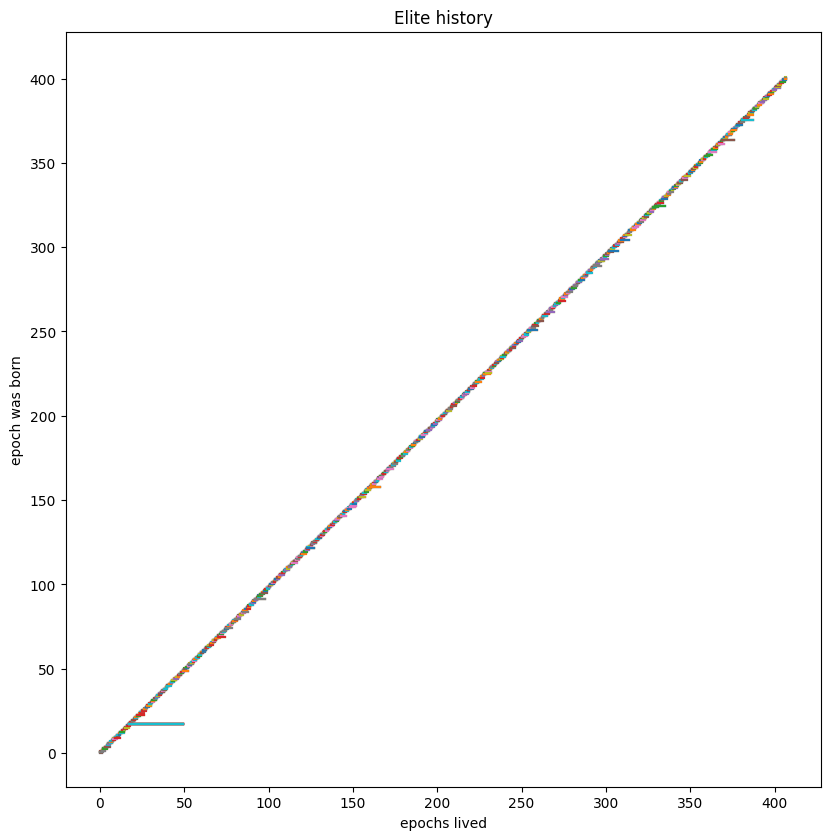

In [54]:
plt.figure(figsize = (10,10), dpi = 100)
for code in tqdm(df_codes_dups):
    x = df_codes.index[(df_codes == code)]
    x_start, x_end = x[0][0], x[-1][0]
    y = code / n_organisms
    plt.plot([x_start, x_end], [y, y], '-')
    
# for i in range(n_epochs):
#     plt.axhline(i, ls=':', color='k', lw=1)
#     plt.axvline(i, ls=':', color='k', lw=1)


plt.ylabel('epoch was born')
plt.xlabel('epochs lived')

plt.axis('square')
plt.title('Elite history')
plt.show()

# Last epoch 

In [17]:
index_epoch = n_generations - 1

In [18]:
genes_last = dump_genes.loc[index_epoch]

genes_last_transformed = genes_last.copy()
genes_last_transformed = genes_last_transformed.apply(lambda row: ga_optim._transform_genes(row), axis=1, raw=True)

loss_last = np.log10(dump_loss[index_epoch].copy())

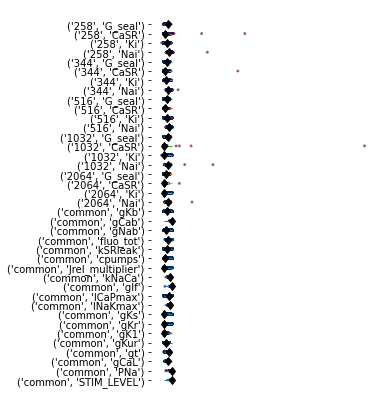

In [19]:
plt.figure(figsize=plt.figaspect(1.8))

ec = m_index.to_frame()['ec_name']
colors = [f'C{i}' for i in (ec != ec.shift()).cumsum() - 1]

y_space = np.arange(len(sol))
plt.hlines(y=np.arange(len(sol)),
           xmin=ga_optim._bounds_transformed[:, 0],
           xmax=ga_optim._bounds_transformed[:, 1],
           colors=colors, lw=1)

for i, g in enumerate(genes_last_transformed.values.T):
    plt.scatter(g, np.full_like(g, y_space[i]),
                marker='.', c=np.isfinite(loss_last), s=16, alpha=0.5, cmap='RdBu')
plt.plot(ga_optim._transform_genes(sol.x), y_space, 'dk')

m_index = config['runtime']['m_index']
plt.yticks(y_space, m_index)
plt.xticks([])

for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.show()

In [20]:
lossort = np.apply_along_axis(np.sort, axis=1, arr=dump_loss)

Text(0.5, 0, 'epoch')

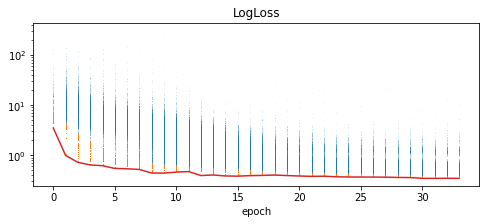

In [21]:
plt.figure(figsize=(8, 3))
start = 0
marker = ','
plt.semilogy(np.arange(len(lossort))[start:], lossort[start:], marker, alpha=0.1, color='C0');
plt.semilogy(np.arange(len(lossort))[start:], lossort[start:, :config['n_elites']], marker, color='C1');

loss = result['dump']['best']['loss']
plt.semilogy(loss, '-', color='C3')

plt.title('LogLoss')
plt.xlabel('epoch')
# plt.legend(loc=7)

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [23]:
pipe = make_pipeline(StandardScaler(), PCA())
df = np.log10(genes_last['common'])
df_pca = pd.DataFrame(pipe.fit_transform(df))

exp_var = (pipe['pca'].explained_variance_ratio_ * 100).astype(int)
exp_var

array([6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3])

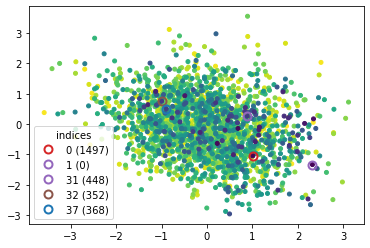

In [24]:
loss_last = np.log10(dump_loss[index_epoch].copy())
argsort = np.argsort(loss_last)
mask_finite = np.isfinite(loss_last[argsort])
n = len(loss_last) // 2
plt.scatter(df_pca.iloc[argsort, 0][mask_finite][:n:][::-1],
            df_pca.iloc[argsort, 1][mask_finite][:n:][::-1],
            c=loss_last[argsort][mask_finite][:n:][::-1],
            alpha=1, s=16)

n_elites = config['n_elites']
indices_highlight = [0, 1, n_elites-1, n_elites, n_elites + 5]

for i in indices_highlight:
    
    index_native = df_pca.iloc[argsort, 0][mask_finite].index.values[i]
    label = f'{i} ({index_native})'
    
    color = f'C{i + 3}'
    
    plt.plot(df_pca.iloc[argsort, 0][mask_finite].iloc[i],
             df_pca.iloc[argsort, 1][mask_finite].iloc[i],
             'o', mec=color, ms=8, mfc='none', mew=2, label=label)
    
plt.legend(title='indices')

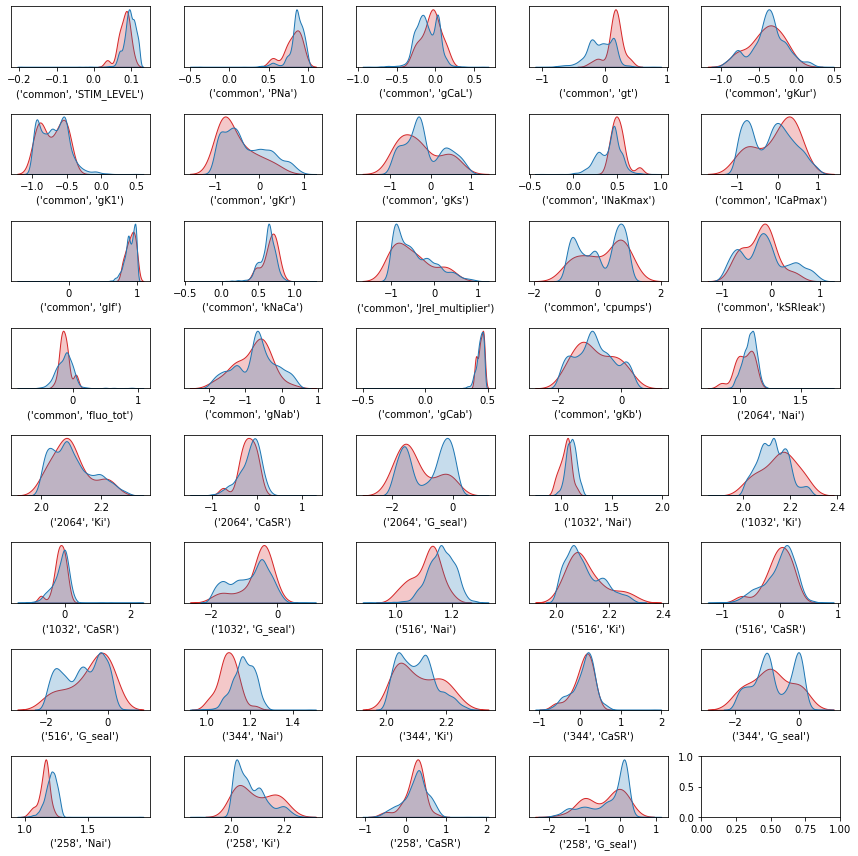

In [25]:
ncols = 5
nrows = int(np.ceil(len(genes_last.columns) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
axes = axes.flatten()

for i, (key, column) in enumerate(genes_last.iteritems()):
    df = column.iloc[argsort].to_frame().copy()
    df = np.log10(df)
    df['elite'] = np.arange(len(df)) < n_elites
    df.columns = [key, 'elite']
    
    ax = axes[i]
    palette = {True: 'C3', False: 'C0'}
    sns.kdeplot(data=df, x=key,
                hue='elite', palette=palette, fill=True,
                common_norm=False, ax=ax, legend=False)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_yticks([])
    ax.set_xlabel(key)

plt.tight_layout()
plt.show()

In [29]:
lossort_last = lossort[index_epoch]
lossort_last_finite = lossort_last[np.isfinite(lossort_last)]

In [30]:
lossort_last_finite = pd.DataFrame(np.log10(lossort_last_finite), columns=['logloss'])
lossort_last_finite['elite'] = False
lossort_last_finite.iloc[:config['n_elites'], -1] = True

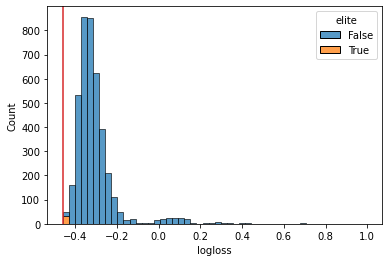

In [31]:
sns.histplot(lossort_last_finite, x='logloss', hue='elite',
             multiple='stack',
             bins=50
             )

plt.axvline(lossort_last_finite['logloss'].iloc[0], color='C3')

Text(0.5, 1.0, 'OUTliers')

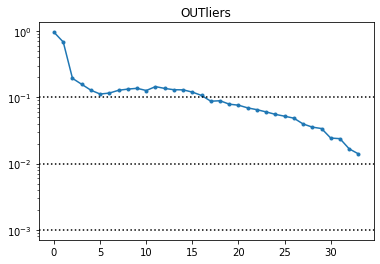

In [32]:
plt.semilogy(np.mean(np.isinf(dump_loss), axis=1) + 1e-4, '.-')
for y in 0.1, 0.01, 0.001:
    plt.axhline(y, ls=':', color='k')
plt.title('OUTliers')

In [33]:
index_dump = 0
index_gen = n_generations - 1

state_bad = dump_states.loc[index_gen, index_dump].unstack(level=0).copy()
state_bad = state_bad.loc[states_index]
genes_bad = dump_genes.loc[index_gen, index_dump].copy()

# Waveforms

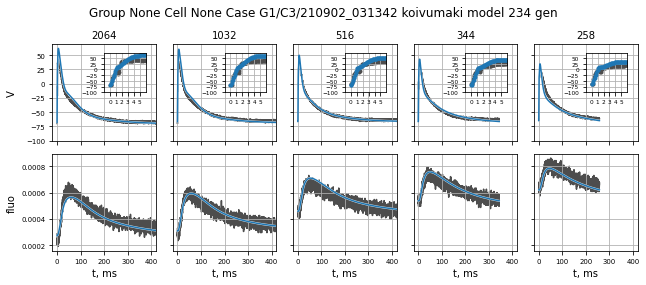

In [47]:
from visualization import plot_waveforms
from pypoptim.helpers import calculate_autoscaling

result_list = [result]
for result in result_list:
    
    config = result['config']
    sol_best = result['sol_best']
    state_best = result['state_best']
    phenotype_best = result['phenotype_best']
    
    filename_so = config['runtime']['filename_so_abs']
    model = CardiacModel(filename_so)
    SolModel.model = model

    config_copy = config.copy()
    del config_copy['t_run']
    config_copy['n_beats'] = 10
    config_copy['n_beats_save'] = 9999999

    SolModel.config = config_copy
    
    sol = SolModel(x=sol_best,
                   state=state_best.copy())
    
#     sol = SolModel(x=genes_bad.copy(),
#                    state=state_bad.copy())

    #sol['phenotype'] = phenotype_best
    
    sol.update()

    exp_cond_dict = {key: value for key, value in config['experimental_conditions'].items() if key != 'common'}

    phenotype_model_last = sol['phenotype']
    
#     sol = SolModel(x=sol_best,
#                    state=state_best.copy())
    
#     sol = SolModel(x=genes_bad.copy(),
#                    state=state_bad.copy())

    # sol['phenotype'] = phenotype_best
    # sol.update()

    exp_cond_dict = {key: value for key, value in config['experimental_conditions'].items() if key != 'common'}

    phenotype_model_last = sol['phenotype']

    model_name = config['filename_so'].split('/')[-2][1:]

    trio = result['trio']
    i_group, i_cell, i_case = trio

    n_generations = len(result['dump']['best']['loss'])

    suptitle = 'Group {} Cell {} Case {} {} model {} gen'.format(*trio, model_name, n_generations)

    phenotype_model = []
    phenotype_control = []

    columns_model = config.get('columns_model', ['V'])
    columns_control = config.get('columns_control', ['V'])

    ylim_ca_bottom = 1e10
    ylim_ca_top = 0

    for e_key, e_value in exp_cond_dict.items():

        y = e_value['phenotype'][columns_control].values.copy()
        x = phenotype_model_last[e_key][columns_model].values[:len(y)].copy()

        if 'composite_' in config['loss']:
            y[:, 1], _, _ = autoscaling(signal_to_scale=y[:, 1],
                                        signal_reference=x[:, 1])    
            y[:, 1] *= 1000
            x[:, 1] *= 1000

            ca_min = min(y[:, 1].min(), x[:, 1].min())
            ca_max = max(y[:, 1].max(), x[:, 1].max())

            ylim_ca_bottom = ca_min if ca_min < ylim_ca_bottom else ylim_ca_bottom
            ylim_ca_top = ca_max if ca_max > ylim_ca_top else ylim_ca_top

        x = np.roll(x.T, 1, axis=1)
        y = np.roll(y.T, 1, axis=1)

        phenotype_model.append(x)
        phenotype_control.append(y)

    if config['loss'] == 'V_CaT_shared':

        phenotype_model_list = []
        phenotype_control_list = []

        for exp_cond_name, exp_cond in config['experimental_conditions'].items():

            if exp_cond_name == 'common':
                continue

            phenotype_control = exp_cond['phenotype'][columns_control].copy()
            phenotype_model   = phenotype_model_last[exp_cond_name][columns_model].values.copy()

            phenotype_model   = phenotype_model[:len(phenotype_control)]
            phenotype_control = phenotype_control[:len(phenotype_model)]

            phenotype_model_list.append(phenotype_model)
            phenotype_control_list.append(phenotype_control.values)

        cat_model_concat = np.concatenate([x[:, 1] for x in phenotype_model_list])
        cat_control_concat = np.concatenate([x[:, 1] for x in phenotype_control_list])

        cat_control_concat_scaled, (alpha, beta) = calculate_autoscaling(signal_to_scale=cat_control_concat,
                                                                         signal_reference=cat_model_concat)

        ylim_ca_bottom = min(*cat_model_concat, *cat_control_concat_scaled)
        ylim_ca_top = max(*cat_model_concat, *cat_control_concat_scaled)

        cumlen = 0
        for i, x in enumerate(phenotype_control_list):

            phenotype_control_list[i][:, 1] = cat_control_concat_scaled[cumlen: cumlen + len(x)]
            cumlen += len(x)

        phenotype_model = []
        phenotype_control = []

        for i in range(len(phenotype_control_list)):
            phenotype_model.append(np.roll(phenotype_model_list[i].T, 1, axis=1))
            phenotype_control.append(np.roll(phenotype_control_list[i].T, 1, axis=1))

    ylim_ca = [ylim_ca_bottom - (ylim_ca_top - ylim_ca_bottom) * 0.05,
               ylim_ca_top    + (ylim_ca_top - ylim_ca_bottom) * 0.05]

    # ylim_ca = None # [0, .2e-3]

    #     with open(os.path.join("../publication/data/voigt/", model_name, suptitle.replace(' ', '_') + '.pickle'), 'wb') as f:
    #         pickle.dump(dict(phenotype_model=phenotype_model,
    #                          phenotype_control=phenotype_control,
    #                          phenotype_model_full={e_key: phenotype_model_last[e_key] for e_key in exp_cond_dict}), f)

    #     continue

    color_model = None if i_group is None else f'C{int(i_group) - 1}'

    points_per_ms = 0.001 / config['t_sampling']

    x_right = 420
    plot_waveforms(phenotype_model, phenotype_control,
           xlim=[-20, x_right], xticks=np.arange(0, x_right, 100),
           yticks_list=[np.arange(-100, 56, 25), None],
           ylim_list=[[-100, 70], ylim_ca],
           titles=list(exp_cond_dict.keys()),
           ylabels=columns_model, xlabel='t, ms', suptitle=suptitle,
           color_model=color_model,
           inset_row_indices=[0], xlim_inset=[-1, 6], xticks_inset=np.arange(0, 6),
           points_per_ms=points_per_ms);

    #     filename = suptitle.replace(' ', '_') + '.png'
    #     dirname_save = '../publication/images/1kHz/ga'
    #     os.makedirs(dirname_save, exist_ok=True)
    #     plt.savefig(os.path.join(dirname_save, filename))

    plt.show()